In [1]:
%matplotlib inline
import sys
sys.path.append(r'C:\Users\festa\OneDrive\Desktop\Thesis\Thesis\functions')
from functions import load_and_process_data, apply_bias_mitigation, evaluate_fairness_metrics, standardize_features, train_classifier_and_find_best_threshold, apply_best_threshold_and_compute_metrics, plot_metrics, train_classifier_on_transformed_data, extract_fairness_metrics
from functions import train_classifier_with_dir, apply_DIR
import numpy as np

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [2]:
#TODO: call MEPS for dir
#should test all of them
#these are the originals
train, val, test, privileged_groups, unprivileged_groups = load_and_process_data('adult', use_disparate_impact_remover=True)

In [3]:
# For Reweighing
#train_transf, test_transf = apply_bias_mitigation('reweighing', train, test, unprivileged_groups, privileged_groups)

# For LFR
#train_transf, test_transf = apply_bias_mitigation('lfr', train, test, unprivileged_groups, privileged_groups)

# For OptimPreproc
#train_transf, test_transf = apply_bias_mitigation('optimpreproc', train, test, unprivileged_groups, privileged_groups)

# For DisparateImpactRemover
train_transf, test_transf = apply_bias_mitigation('disparateimpactremover', train, test, unprivileged_groups, privileged_groups)


In [4]:
train_before_stat_parity_diff, train_before_disp_impact = evaluate_fairness_metrics(train, unprivileged_groups, privileged_groups, "Train Dataset (Before Transformation)")
test_before_stat_parity_diff, test_before_disp_impact = evaluate_fairness_metrics(test, unprivileged_groups, privileged_groups, "Test Dataset (Before Transformation)")

train_after_stat_parity_diff, train_after_disp_impact = evaluate_fairness_metrics(train_transf, unprivileged_groups, privileged_groups, "Train Dataset (After Transformation)")
test_after_stat_parity_diff, test_after_disp_impact = evaluate_fairness_metrics(test_transf, unprivileged_groups, privileged_groups, "Test Dataset (After Transformation)")

print("Train Dataset (Before Transformation) - Statistical Parity Difference:", train_before_stat_parity_diff)
print("Train Dataset (Before Transformation) - Disparate Impact:", train_before_disp_impact)
print("Test Dataset (Before Transformation) - Statistical Parity Difference:", test_before_stat_parity_diff)
print("Test Dataset (Before Transformation) - Disparate Impact:", test_before_disp_impact)

print("Train Dataset (After Transformation) - Statistical Parity Difference:", train_after_stat_parity_diff)
print("Train Dataset (After Transformation) - Disparate Impact:", train_after_disp_impact)
print("Test Dataset (After Transformation) - Statistical Parity Difference:", test_after_stat_parity_diff)
print("Test Dataset (After Transformation) - Disparate Impact:", test_after_disp_impact)


Train Dataset (Before Transformation) - Statistical Parity Difference: -0.1951
Train Dataset (Before Transformation) - Disparate Impact: 0.3572
Test Dataset (Before Transformation) - Statistical Parity Difference: -0.1893
Test Dataset (Before Transformation) - Disparate Impact: 0.3812
Train Dataset (After Transformation) - Statistical Parity Difference: -0.1951
Train Dataset (After Transformation) - Disparate Impact: 0.3572
Test Dataset (After Transformation) - Statistical Parity Difference: -0.1893
Test Dataset (After Transformation) - Disparate Impact: 0.3812


In [5]:
# Standardize the features (scaling)
train, val, test = standardize_features(train, val, test)

# Choose classifier type
classifier_type = 'logistic_regression'  # Change to 'random_forest' or 'xgboost'

# Step 1: Train classifier
classifier, best_threshold, best_balanced_acc = train_classifier_and_find_best_threshold(train, val, classifier_type, unprivileged_groups, privileged_groups)


Best Threshold: 0.44
Best Balanced Accuracy: 0.7662474868618181


In [6]:
test_metrics, test_scores = apply_best_threshold_and_compute_metrics(classifier, test, best_threshold, unprivileged_groups, privileged_groups)

Balanced Accuracy (test): 0.7452190474454254
Statistical Parity Difference (test): -0.4153364361135144
Disparate Impact (test): 0.24706800999584924
Average Odds Difference (test): -0.3549770053384391
Equal Opportunity Difference (test): -0.38079950289975145
Theil Index (test): 0.10642257246635718


In [ ]:

def plot_metrics_dir(test, test_scores, best_threshold, unprivileged_groups, privileged_groups, thresholds=np.arange(0.01, 1, 0.01)):

    test_balanced_accs = []
    test_disp_impacts = []
    test_avg_odds_diffs = []

    for threshold in thresholds:
        test_predictions = (test_scores >= threshold).astype(int)
        test_with_scores = copy.deepcopy(test)
        test_with_scores.labels = test_predictions.reshape(-1, 1)

        # Compute fairness and performance metrics
        test_metric = ClassificationMetric(test, test_with_scores, unprivileged_groups, privileged_groups)
        
        test_balanced_accs.append((test_metric.true_positive_rate() + test_metric.true_negative_rate()) / 2)
        test_disp_impacts.append(test_metric.disparate_impact())
        test_avg_odds_diffs.append(test_metric.average_odds_difference())

    # Plot Balanced Accuracy and Fairness Metrics
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Balanced Accuracy
    ax1.plot(thresholds, test_balanced_accs, label="Balanced Accuracy", color="blue", linewidth=2)
    ax1.set_xlabel("Threshold", fontsize=14)
    ax1.set_ylabel("Balanced Accuracy", color="blue", fontsize=14)
    ax1.tick_params(axis='y', labelcolor="blue")
    ax1.grid()

    # Secondary y-axis for Disparate Impact and Average Odds Difference
    ax2 = ax1.twinx()
    ax2.plot(thresholds, test_disp_impacts, label="Disparate Impact", color="orange", linestyle="--", linewidth=2)

    #ax2.set_ylim(-0.05, 0.05)
    #ax2.set_ylim(-0.05, 3)
    ax2.set_ylabel("Fairness Metrics", color="red", fontsize=14)
    ax2.tick_params(axis='y', labelcolor="red")

    # Highlight the best threshold
    ax1.axvline(best_threshold, color='green', linestyle='--', linewidth=2, label="Best Threshold")

    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    fig.legend(lines1 + lines2, labels1 + labels2, loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=12)

    # Title and layout adjustments
    fig.suptitle("Test Metrics vs Threshold (transformed test data)", fontsize=16)
    fig.tight_layout()
    plt.show()


def plot_metrics_dir(test, test_scores, best_threshold, unprivileged_groups, privileged_groups, thresholds=np.arange(0.01, 1, 0.01)):

    test_balanced_accs = []
    test_disp_impacts = []
    test_avg_odds_diffs = []

    for threshold in thresholds:
        test_predictions = (test_scores >= threshold).astype(int)
        test_with_scores = copy.deepcopy(test)
        test_with_scores.labels = test_predictions.reshape(-1, 1)

        # Compute fairness and performance metrics
        test_metric = ClassificationMetric(test, test_with_scores, unprivileged_groups, privileged_groups)
        
        test_balanced_accs.append((test_metric.true_positive_rate() + test_metric.true_negative_rate()) / 2)
        test_disp_impacts.append(test_metric.disparate_impact())
        test_avg_odds_diffs.append(test_metric.average_odds_difference())

    # Plot Balanced Accuracy and Fairness Metrics
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Balanced Accuracy
    ax1.plot(thresholds, test_balanced_accs, label="Balanced Accuracy", color="blue", linewidth=2)
    ax1.set_xlabel("Threshold", fontsize=14)
    ax1.set_ylabel("Balanced Accuracy", color="blue", fontsize=14)
    ax1.tick_params(axis='y', labelcolor="blue")
    ax1.grid()

    # Secondary y-axis for Disparate Impact and Average Odds Difference
    ax2 = ax1.twinx()
    ax2.plot(thresholds, test_disp_impacts, label="Disparate Impact", color="orange", linestyle="--", linewidth=2)

    #ax2.set_ylim(-0.05, 0.05)
    #ax2.set_ylim(-0.05, 3)
    ax2.set_ylabel("Fairness Metrics", color="red", fontsize=14)
    ax2.tick_params(axis='y', labelcolor="red")

    # Highlight the best threshold
    ax1.axvline(best_threshold, color='green', linestyle='--', linewidth=2, label="Best Threshold")

    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    fig.legend(lines1 + lines2, labels1 + labels2, loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=12)

    # Title and layout adjustments
    fig.suptitle("Test Metrics vs Threshold (transformed test data)", fontsize=16)
    fig.tight_layout()
    plt.show()

In [7]:
plot_metrics(test, test_scores, best_threshold, unprivileged_groups, privileged_groups)


c:\Users\festa\OneDrive\Desktop\Thesis\Thesis\functions.py:332: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [ ]:
# Train classifier on transformed data and use the same threshold
classifier_type = 'logistic_regression'  # Change to 'random_forest' or 'xgboost'

test_transf_metrics_df = train_classifier_with_dir(
    train, test, classifier_type, best_threshold, unprivileged_groups, privileged_groups, sensitive_attribute="sex", repair_levels=np.linspace(0., 1., 11))


=== Repair Level: 0.0 ===

=== Repair Level: 0.1 ===

=== Repair Level: 0.2 ===

=== Repair Level: 0.30000000000000004 ===

=== Repair Level: 0.4 ===

=== Repair Level: 0.5 ===

=== Repair Level: 0.6000000000000001 ===

=== Repair Level: 0.7000000000000001 ===

=== Repair Level: 0.8 ===

=== Repair Level: 0.9 ===

=== Repair Level: 1.0 ===

Results for Various Repair Levels:
    Repair Level  Balanced Accuracy  Statistical Parity Difference  \
0            0.0           0.734962                      -0.145973   
1            0.1           0.731719                      -0.137177   
2            0.2           0.732836                      -0.130598   
3            0.3           0.729598                      -0.120141   
4            0.4           0.728109                      -0.108272   
5            0.5           0.724315                      -0.089430   
6            0.6           0.723483                      -0.074875   
7            0.7           0.720404                      -0.0

In [8]:
chosen_repair_level = 1.0
# Apply bias mitigation
test_transf_classifier, test_transf_scores, test_transf_metrics = apply_DIR(train, test, chosen_repair_level, classifier_type, best_threshold, unprivileged_groups, privileged_groups, sensitive_attribute="sex")




=== Repair Level: 1.0 ===

Results for Various Repair Levels:
   Repair Level  Balanced Accuracy  Statistical Parity Difference  \
0           1.0           0.715777                      -0.045582   

   Disparate Impact  Average Odds Difference  Equal Opportunity Difference  \
0          0.890715                  0.02068                     -0.003926   

   Theil Index  
0     0.121473  


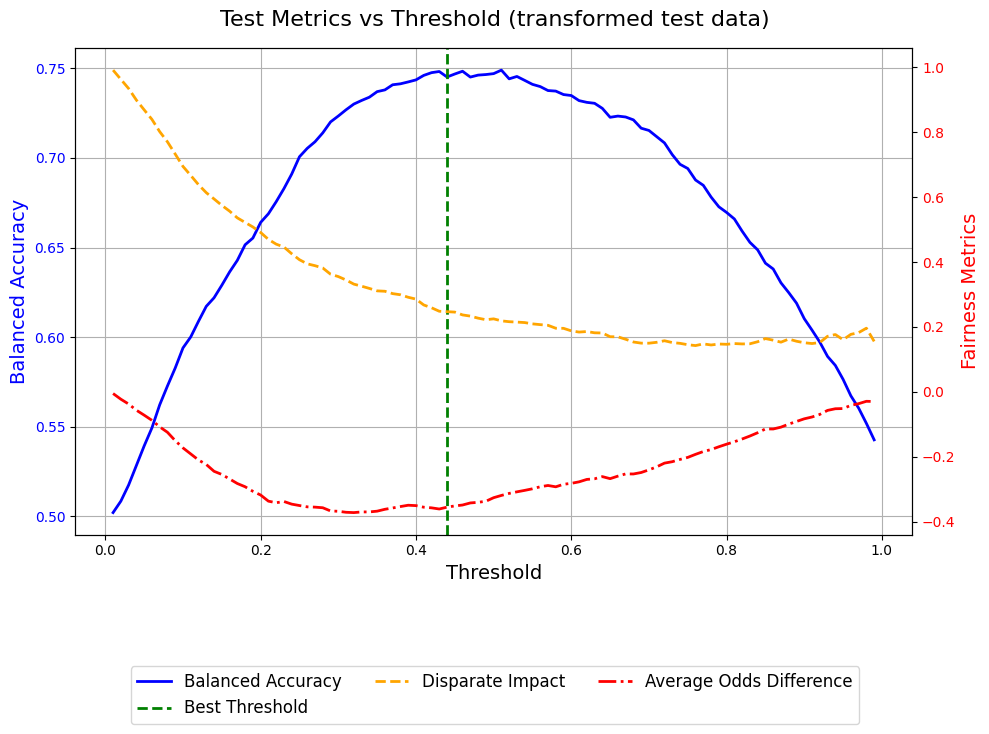

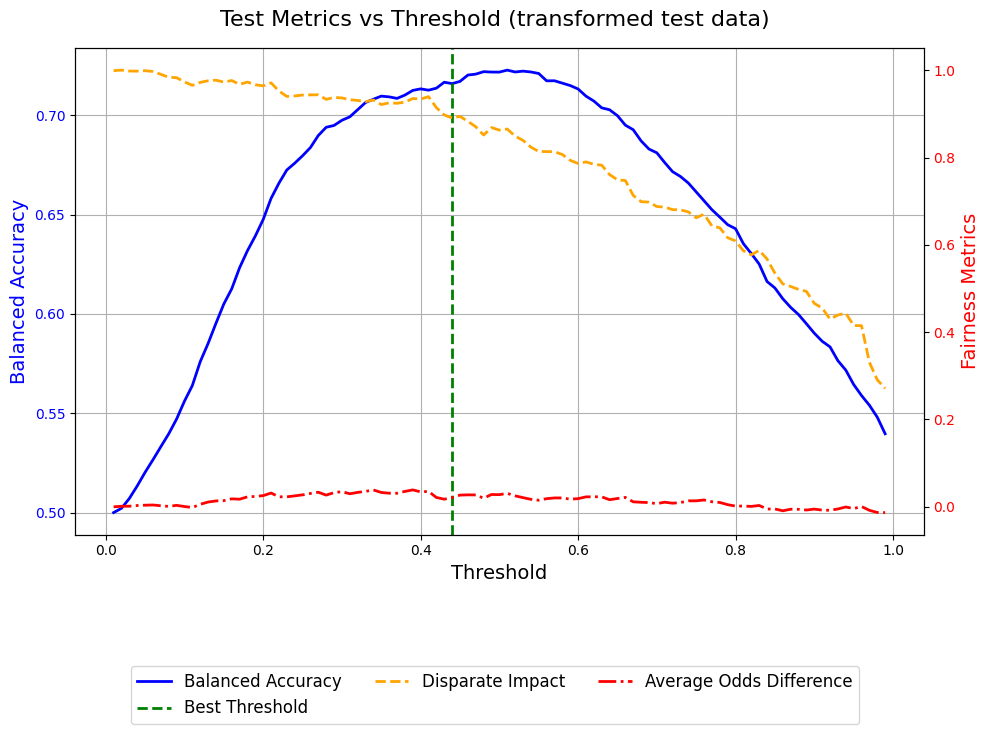

In [9]:
%matplotlib inline
plot_metrics(test_transf, test_transf_scores, best_threshold, unprivileged_groups, privileged_groups)

In [10]:
fairness_metrics, validation_metrics, test_metrics = extract_fairness_metrics(
    train_before_stat_parity_diff, train_after_stat_parity_diff,
    test_before_stat_parity_diff, test_after_stat_parity_diff,
    train_before_disp_impact, train_after_disp_impact,
    test_before_disp_impact, test_after_disp_impact,
    best_threshold, best_balanced_acc,
    test_metrics, test_transf_metrics
)

# Displaying the tables
for table in [fairness_metrics, validation_metrics, test_metrics]:
    display(table.name)
    display(table)


KeyError: 'balanced_accuracy'

In [11]:
test_transf_metrics

{'balanced Accuracy': 0.7157770775983778,
 'statistical Parity Difference': -0.045581945861488116,
 'disparate Impact': 0.8907150503879714,
 'average Odds Difference': 0.020679722749910923,
 'equal Opportunity Difference': -0.003925962190253762,
 'theil Index': 0.12147282979249066}

In [14]:
test_metrics

{'balanced_accuracy': 0.7452190474454254,
 'statistical_parity_difference': -0.4153364361135144,
 'disparate_impact': 0.24706800999584924,
 'average_odds_difference': -0.3549770053384391,
 'equal_opportunity_difference': -0.38079950289975145,
 'theil_index': 0.10642257246635718}